In [1]:
# load vine dataset from scikit-learn
import torch 
from matplotlib import pyplot as plt
from sklearn.datasets import load_wine
torch.manual_seed(1234)

# load dataset
data = load_wine()
import pandas as pd
df=pd.DataFrame(data["data"],columns=data["feature_names"])
y=df["alcohol"]
x=df.drop("alcohol",axis=1)

In [2]:
# scale data

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

x=pd.DataFrame(x_scaled,columns=x.columns)
x.head()

,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


In [3]:

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1234)
x_train_tensor=torch.tensor(x_train.values, dtype=torch.float32)

In [4]:


def root_mean_squared_error(y_hat,y):
    return torch.sqrt(torch.mean((y_hat-y)**2))

# get_batch liefert ein Tupel (x,y) mit x.shape = (batch_size, n_features) und y.shape = (batch_size, 1)
# bei batch_size 10 bekommen wir also 10 zufällige Datenpunkte. x.shape ist dann (10, 13) und y.shape (10, 1)
def get_batch(x,y,batch_size):
    for i in range(0,len(x),batch_size):
        # yield: return a generator
        yield x[i:i+batch_size],y[i:i+batch_size]

In [5]:
class MyModel(torch.nn.Module):    # erbt von torch.nn.Module
    def __init__(self):             # Konstruktor
        super(MyModel, self).__init__()   # Aufruf des Super-Konstruktors
        self.fc1 = torch.nn.Linear(12, 10)    # Fully-Connected-Layer mit 12 Eingangsneuronen und 10 Ausgangsneuronen
        self.fc2 = torch.nn.Linear(10, 1)     # Fully-Connected-Layer mit 10 Eingangsneuronen und 1 Ausgangsneuronen
        self.batch_norm = torch.nn.BatchNorm1d(10)  # Batch-Normalization-Layer mit 10 Neuronen
        self.relu=torch.nn.ReLU()   # ReLU-Aktivierungsfunktion

    def forward(self, xb):
        xb = self.relu(self.fc1(xb))   # a2
        xb = self.batch_norm(xb)  # a2_norm=a2-mean/std
        xb = self.fc2(xb)
        return xb

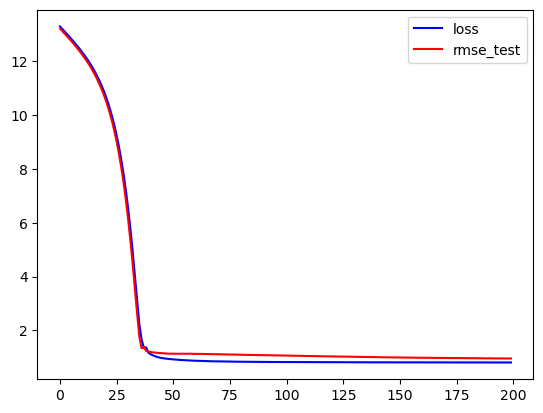

In [6]:
lr=0.005
wd=0.1
batch_size=10
torch.manual_seed(1234)

epochs=200
losses=[]
rmse_test=[]
hidden_count=20

model=MyModel()

y_train_tensor=torch.tensor(y_train.values, dtype=torch.float32)
x_test_tensor=torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test.values, dtype=torch.float32)
for i in range(epochs):
    losses_in_epoch=[]
    # trainiere jeweils mit einer kleinen Auswahl an Daten, der Batch
    # xb: ist die Auswahl der Daten für die Inputneuronen
    # yb: ist die Auswahl der Daten für die Outputneuronen
    for xb,yb in get_batch(x_train_tensor,y_train_tensor,batch_size):
        y_hat=model(xb)
        loss=root_mean_squared_error(y_hat, yb)
        losses_in_epoch.append(loss.item())
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():    # model.parameters() gibt alle Gewichte und Biasse zurück (w1, w2, b1, etc.)
                param.sub_(lr*param.grad)
            model.zero_grad()
    losses.append(sum(losses_in_epoch)/len(losses_in_epoch))
    y_test_hat=model(x_test_tensor)
    y_test_rmse=root_mean_squared_error(y_test_hat, y_test_tensor)
    rmse_test.append(y_test_rmse.item())

plt.plot(range(epochs),losses, color="blue")
plt.plot(range(epochs),rmse_test, color="red")
plt.legend(["loss", "rmse_test"])
plt.show()


In [7]:
y_test_hat=model(x_test_tensor)
rmse_test=root_mean_squared_error(y_test_hat, y_test_tensor)
rmse_test.item()

0.9545404314994812

In [8]:
y_train_hat=model(x_train_tensor)
rmse_train=root_mean_squared_error(y_train_hat, y_train_tensor)
rmse_train.item()


0.8470990061759949

In [9]:
y_test_hat

tensor([[12.2715],
        [14.0320],
        [12.7861],
        [12.4891],
        [13.2118],
        [12.7978],
        [13.5331],
        [12.9791],
        [13.1431],
        [13.0390],
        [13.1368],
        [12.7623],
        [12.9758],
        [13.0844],
        [13.4615],
        [13.4340],
        [13.0241],
        [13.5469],
        [13.3428],
        [12.6561],
        [12.9461],
        [13.6223],
        [13.1230],
        [12.7327],
        [13.0026],
        [12.6427],
        [14.7200],
        [13.1037],
        [13.0225],
        [12.8579],
        [12.7806],
        [12.0778],
        [12.8355],
        [11.9475],
        [14.5035],
        [12.5634]], grad_fn=<AddmmBackward0>)